In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

In [96]:
N = 10

In [98]:
Point = [[np.random.randint(100), np.random.randint(100)] for i in range(N)]
#Point = [[10,10],[90,90],[10,90],[90,10],[20,15],[15,20]]

np_Point = np.array(Point)
print(Point)

[[19, 45], [39, 15], [78, 0], [4, 37], [72, 66], [55, 24], [54, 95], [10, 12], [76, 36], [82, 75]]


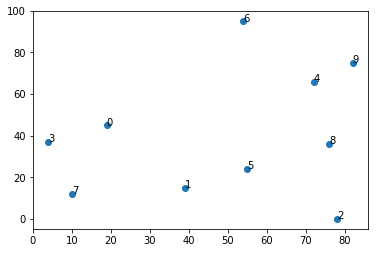

In [99]:
text = [i for i in range(N)]

plt.scatter(np_Point[:,0],np_Point[:,1])

for i, txt in enumerate(text):
    plt.annotate(txt,(np_Point[i][0],np_Point[i][1]))
plt.show()

In [100]:
tmp_Dist = []
tmp_Index = []
for i in range(N):
    for j in range(i,N):
        x1, y1 = Point[i]
        x2, y2 = Point[j]
        
        if (i == j):
            tmp_Dist.append(1)
        else:
            tmp_Dist.append(np.sqrt((x1-x2)**2 + (y2-y1)**2))
        tmp_Index.append([i,j])

    
Dist = np.array(tmp_Dist)
Index = np.array(tmp_Index)

#for idx, dist in zip(Index,Dist):
#    print (idx, dist)

print (Dist.mean()*N)


454.071829137


In [102]:
import tensorflow as tf
tf.GraphKeys.VARIABLES = tf.GraphKeys.GLOBAL_VARIABLES

## Q-Network Approach

In [103]:
len_N = len(Dist)
n_inputs = N

In [104]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])

        # He Initalization
        stddev = np.sqrt(2/n_inputs)
        
        # Xavier
        #stddev = 1/np.sqrt(n_inputs)
        
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        
        # DropOut
        #keep_prob = 0.2
        #drop_out = tf.nn.dropout(Z, keep_prob)
        
        # Batch Nomalization
        batch_mean,batch_var = tf.nn.moments(Z,[0])
        scale = tf.Variable(tf.ones([n_neurons]))
        beta  = tf.Variable(tf.zeros([n_neurons]))
        Z_batch = tf.nn.batch_normalization(Z,batch_mean,batch_var,beta,scale,1e-3)
        
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [105]:
class Qnetwork():
    def __init__(self,n_inputs,neuron_layer):

        self.n_hidden1 = 40
        self.n_hidden2 = 40

        self.X = tf.placeholder(shape=(None,n_inputs),dtype=tf.float32,name="X")
        self.hidden1 = neuron_layer(self.X, self.n_hidden1, name="hidden1",
                               activation=tf.nn.relu)
        self.hidden2 = neuron_layer(self.hidden1, self.n_hidden2, name="hidden2",
                               activation=tf.nn.relu)

        self.streamAC, self.streamVC = tf.split(self.hidden2,[self.n_hidden2//2,self.n_hidden2//2],1)

        self.Advantage = neuron_layer(self.streamAC,N,name = "A-Network")
        self.Value = neuron_layer(self.streamVC,1,name = "V-Network")

        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)

        self.targetQ = tf.placeholder(shape = [None], dtype=tf.float32)
        self.actions = tf.placeholder(shape = [None], dtype=tf.int32)

        self.actions_onehot = tf.one_hot(self.actions,n_inputs,dtype=tf.float32)

        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis = 1)

        self.td_error = tf.square(self.targetQ-self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate = 0.00001)
        self.updateModel = self.trainer.minimize(self.loss)

In [106]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [107]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) 
                                                          + ((1-tau)*tfVars[idx+total_vars//2].value())))

    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [113]:
batch_size = 200
update_freq = 50
y = 0.5
startE = 1
endE = 0.1
annealing_steps = 10000.
num_episodes = 20001
pre_train_steps = 100
max_epLength = N-1
tau = 0.001

path = "./dddqn_TSP"

In [114]:
tf.reset_default_graph()
mainQN = Qnetwork(N,neuron_layer)
targetQN = Qnetwork(N,neuron_layer)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables,tau)
myBuffer = experience_buffer()

9e-05
0 / 20001 675.645836729 675.645836729 1
100 / 20001 390.243048433 553.02943225 0.9271899999999721
200 / 20001 390.243048433 552.441153651 0.846189999999941
300 / 20001 390.243048433 554.159128186 0.76518999999991
400 / 20001 389.527125375 552.364816827 0.684189999999879
500 / 20001 383.530078769 554.56964404 0.6031899999998479
600 / 20001 383.530078769 555.792422116 0.5221899999998169
700 / 20001 383.530078769 557.335880142 0.4411899999998221
800 / 20001 360.128719597 557.978419025 0.360189999999841
900 / 20001 360.128719597 560.788481255 0.27918999999985994
1000 / 20001 360.128719597 563.070802104 0.19818999999986286
1100 / 20001 360.128719597 566.383629148 0.1171899999998568
1200 / 20001 360.128719597 568.960457557 0.09999999999985551
1300 / 20001 360.128719597 572.174926443 0.09999999999985551
1400 / 20001 360.128719597 575.185852434 0.09999999999985551
1500 / 20001 360.128719597 577.084962105 0.09999999999985551
1600 / 20001 360.128719597 578.797754461 0.09999999999985551
170

13500 / 20001 336.946207169 591.420774629 0.09999999999985551
13600 / 20001 336.946207169 591.24629442 0.09999999999985551
13700 / 20001 336.946207169 591.170337257 0.09999999999985551
13800 / 20001 336.946207169 591.179393244 0.09999999999985551
13900 / 20001 336.946207169 591.18927073 0.09999999999985551
14000 / 20001 336.946207169 591.184958316 0.09999999999985551
14100 / 20001 336.946207169 591.302414191 0.09999999999985551
14200 / 20001 336.946207169 591.537805804 0.09999999999985551
14300 / 20001 336.946207169 591.645842234 0.09999999999985551
14400 / 20001 336.946207169 591.8552152 0.09999999999985551
14500 / 20001 336.946207169 591.824714692 0.09999999999985551
14600 / 20001 336.946207169 591.652715329 0.09999999999985551
14700 / 20001 336.946207169 591.805538728 0.09999999999985551
14800 / 20001 336.946207169 591.902542675 0.09999999999985551
14900 / 20001 336.946207169 592.051623267 0.09999999999985551
15000 / 20001 336.946207169 592.334616153 0.09999999999985551
15100 / 2000

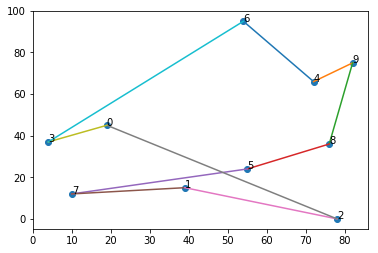

[-0.53192925  0.12853509  0.12713973  0.12452786  0.12566745  0.12845771
 -0.64253414 -0.10289644  0.12031093  0.1220535 ] 0.128535
[-0.09964943 -0.08522174  0.07075055 -0.46423918 -0.16977862 -0.15219134
 -0.47498119  0.13503402  0.12085792  0.1177223 ] 0.135034
[ 0.11870122 -0.34042069 -0.07126915  0.07578471  0.11059082 -0.24099576
  0.11148283 -0.02272737 -0.06482244 -0.2315051 ] 0.118701
[ 0.09208804 -0.22566271  0.05598242  0.06058913 -0.18198621 -0.16853194
 -0.14544323  0.0147123  -0.15019634 -0.37106943] 0.092088
[ 0.09375787 -0.01026417  0.06033786  0.01993418 -0.39490551 -0.15687057
 -0.41040766  0.10562974 -0.15475568  0.01133668] 0.10563
[-0.34466264 -0.37115523 -0.1076185  -0.3516371   0.05445176  0.09631942
 -0.01989746  0.04384106 -0.05657426 -0.0043505 ] 0.0963194
[-0.02307159  0.14879599  0.12822205  0.1467604   0.13006139 -0.34579039
 -0.24093233 -0.21945393  0.14696014  0.14754838] 0.148796
[-0.02216214  0.12777391 -0.15941852 -0.14246716 -0.0008278   0.1296168
 -0.

In [115]:
#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps
print(stepDrop)

#create lists to contain total rewards and steps per episode
jList = []
rList = []
pair = []
total_steps = 0
best = 10**6

if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)

    for i in range(num_episodes):
       
        episodeBuffer = experience_buffer()

        #Reset environment and get first new observation
        S = [0 for i in range(N)]
        start = np.random.randint(N)
        S[start] = 1
        s0 = start
        
        d = False
        j = 0
        r = 0
        tmp_r = 0

        tmp_trajectory = [0 for dummy in range(N)]
        tmp_trajectory[start] = 1
        
        while j < max_epLength:
            
            j+=1
            
            #trajectory = np.where(np.array(S) == 0)[0]
            trajectory = np.where(np.array(tmp_trajectory) == 0)[0]

            if np.random.rand(1) < e:
                tmp_tra = trajectory.copy()
                a = np.random.choice(tmp_tra,1,replace=False)[0]

            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.X:[S]})[0]

                if (a not in trajectory):
                    Q_List = sess.run(mainQN.Qout,feed_dict={mainQN.X:[S]})[0]
                    lQ_List = list(Q_List)

                    while(1):
                        #print(lQ_List)
                        a = lQ_List.index(max(lQ_List))
                        if (a not in trajectory):
                            lQ_List[a] = -999
                        else:
                            break

            # For reward
            p1, p2 = min(s0,a), max(s0,a)
            idx = Index.tolist().index([p1,p2])
            tmp_r += Dist[idx]
            #print (p1,p2)
            
            S1 = S.copy()
            
            
            ## State Var
            #S1[a] = j+1
            
            S1 = [0 for dummy in range(N)]

            S1[a] = 1
            
            pair.append([s0,a])
            
            
            #reward for each node
            #r = 2/float(tmp_r)
            if (j == max_epLength):
                p1, p2 = min (start,a), max(start,a)
                tmp_r += Dist[idx]
                #print (p1,p2)

                """
                if (rList):
                    #r = 2/float(tmp_r - min(rList))
                    if (tmp_r - sum(rList)/len(rList)):
                        r = 2/float(tmp_r - sum(rList)/len(rList))
                    else:
                        r = 0
                    
                    #r = 2/float(tmp_r)
                else:
                    r = 2/float(tmp_r)
                """ 
                r = 2/float(tmp_r)
                    
                rList.append(tmp_r)
                d = True

            # Step update
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([S,a,r,S1,d]),[1,5]))
            
            if (total_steps > pre_train_steps):
                if e >= endE:
                    e -= stepDrop
                    
                if total_steps % update_freq == 0:
            
                    trainBatch = myBuffer.sample(batch_size)
                    
                    Q1 = sess.run(mainQN.predict, feed_dict = {mainQN.X: np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout, feed_dict = {targetQN.X: np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    
                    #print(trainBatch[:,4])
                    #print(trainBatch[:,4]-1)
                    #print(-(trainBatch[:,4]-1))
                    #input()
                    
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ*end_multiplier)
                    
                    # update the network with our target values.
                    _ = sess.run(mainQN.updateModel,
                                feed_dict = {mainQN.X: np.vstack(trainBatch[:,0]),
                                             mainQN.targetQ: targetQ,
                                             mainQN.actions: trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess)
                        
            #Update the State
            S = S1.copy()
            s0 = a
            myBuffer.add(episodeBuffer.buffer)
            tmp_trajectory[a] = 1
            #print(S)
            
        # Save for route
        pair.append([a,start])
        #print (pair)
        #print (best, tmp_r)
        if (tmp_r < best):
            #print (best)
            best_pair = pair.copy()
            best = tmp_r
        pair = []
            
        if (i % 100 == 0):
            print (i,"/",num_episodes,min(rList),sum(rList)/len(rList),e)
            #rList = [sum(rList)/len(rList)]
            #rList = []

    saver.save(sess,path+'/model-'+str(i)+'.ckpt')


    text = [i for i in range(N)]
    print (best_pair,best)
    plt.scatter(np_Point[:,0],np_Point[:,1])

    for i, txt in enumerate(text):
        plt.annotate(txt,(np_Point[i][0],np_Point[i][1]))

    for fr, to in best_pair:
        plt.plot([Point[fr][0],Point[to][0]],[Point[fr][1],Point[to][1]])
    plt.show()
    
    for idx_test in range(N):
        S = [0 for i in range(N)]
        S[idx_test] = 1
        Q_List = sess.run(mainQN.Qout,feed_dict={mainQN.X:[S]})[0]
        print (Q_List, max(Q_List))

1061.03960988
[[1, 8], [8, 15], [15, 17], [17, 3], [3, 5], [5, 2], [2, 12], [12, 18], [18, 10], [10, 19], [19, 4], [4, 13], [13, 11], [11, 7], [7, 0], [0, 9], [9, 6], [6, 16], [16, 14], [14, 1]]


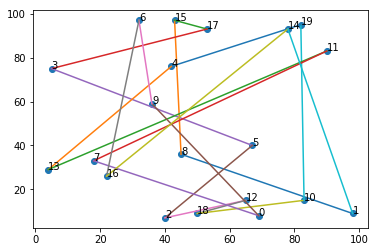

In [38]:
pair = []
total_dist = 0
load_model = False
with tf.Session() as sess:
    sess.run(init)
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)

    best = N*10000000
    best_pair = []
    
    for just in range(10):
        for start in range(N):
            #print (just,start)
            
            S = [0 for i in range(N)]
            S[start] = 1
            s0 = start
            
            tmp_trajectory = [0 for dummy in range(N)]
            tmp_trajectory[start] = 1
            
            j = 0

            while j < max_epLength:
            
                j+=1

                #trajectory = np.where(np.array(S) == 0)[0]
                trajectory = np.where(np.array(tmp_trajectory) == 0)[0]
                
                if np.random.rand(1) < e:
                    tmp_tra = trajectory.copy()
                    a = np.random.choice(tmp_tra,1,replace=False)[0]

                else:
                    a = sess.run(mainQN.predict,feed_dict={mainQN.X:[S]})[0]

                    if (a not in trajectory):
                        Q_List = sess.run(mainQN.Qout,feed_dict={mainQN.X:[S]})[0]
                        lQ_List = list(Q_List)

                        while(1):
                            #print(lQ_List)
                            a = lQ_List.index(max(lQ_List))
                            if (a not in trajectory):
                                lQ_List[a] = -999
                            else:
                                break

                # For reward
                p1, p2 = min(s0,a), max(s0,a)
                idx = Index.tolist().index([p1,p2])
                tmp_r += Dist[idx]
                
                pair.append([s0,a])
                
                #S[a] = j+1
                
                #S[a] = 1
                
                S = [0 for i in range(N)]
                S[a] = 1
                tmp_trajectory[a] = 1
                
                s0 = a
                
                
            pair.append([a,start])

            if (tmp_r < best):
                best_pair = pair.copy()
                best = tmp_r
                tmp_r = 0

            pair = []
            total_dist = 0

    print(best)
    print(best_pair)
    
text = [i for i in range(N)]

plt.scatter(np_Point[:,0],np_Point[:,1])

for i, txt in enumerate(text):
    plt.annotate(txt,(np_Point[i][0],np_Point[i][1]))
    
for fr, to in best_pair:
    plt.plot([Point[fr][0],Point[to][0]],[Point[fr][1],Point[to][1]])
plt.show()

In [17]:
pair = []
load_model = False
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
        
    for i in range(N):
        tmp_input = [0 for i in range(N)]
        tmp_input[i] = 1
        Q1 = sess.run(mainQN.predict,feed_dict={mainQN.X: [tmp_input]})[0]
        pair.append([i,Q1])

In [17]:
print (pair)

[[0, 0], [1, 5], [2, 1], [3, 6], [4, 0], [5, 6], [6, 0], [7, 0], [8, 7], [9, 2]]


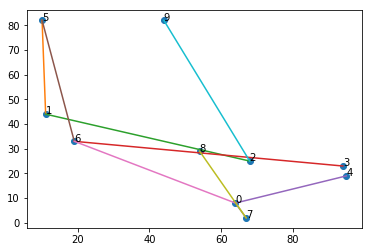

In [18]:
text = [i for i in range(N)]

plt.scatter(np_Point[:,0],np_Point[:,1])

for i, txt in enumerate(text):
    plt.annotate(txt,(np_Point[i][0],np_Point[i][1]))
    
for fr, to in pair:
    plt.plot([Point[fr][0],Point[to][0]],[Point[fr][1],Point[to][1]])
plt.show()